---

title: "Python for Hardware Engineers: Analyzing Temperature and Humidity Data From an OM-24 Sensor"
subtitle: ""
summary: ""
authors: []
tags: ["sensor","data","python","hardware","engineering","science","excel"]
categories: []
date: 2020-10-31
lastmod: 2020-10-18T12:58:26-04:00
featured: false
draft: false

image:
  caption: ""
  focal_point: ""
  preview_only: false

projects: []
---

Data analysis of sensor data is a typical hardware engineering activity that often involves an Excel-based workflow. 
While Excel (and other spreadsheet tools) are great for quick and dirty, one-off analyses, a [Python](https://www.python.org/) + [`pandas`](pandas.pydata.org/) workflow can really takes things to the next level.

In this post, we'll be analyzing sensor data from an [`Omega OM-24 Temperature and Humidity Data Logger`](https://www.omega.ca/en/control-and-monitoring-devices/data-loggers/temperature-and-humidity-data-loggers/om-22-series/p/OM-24) using a modern data analysis workflow. 
Hardware engineers should be very familiar with Omega, as they are a quick and easy online vendor of a wide range of sensors.
The `OM-24` is an example of a simple, low-cost, no frills sensor: there's no fancy wiring to do, no difficult calibrations, just turn it on and start recording.

![OM-24 Temperature and Humidity Sensor](2020-10-21-07-52-39.png)

Fetching the data is even easier: plug in the sensor's USB connection and copy the "Excel" data.
However, this is where we come to our first bit of weirdness.
According to the sensor's user manual:

![Sensor's Data Formatting](2020-10-21-08-01-18.png)

What the user manual is really trying to say is that the logger formats the data as [Tab-separated values (TSV)](https://en.wikipedia.org/wiki/Tab-separated_values).
The extension should have ideally been `.tsv`.
This won't cause us any problems in our workflow, but will be something to keep in mind when importing and extracting the data.

In the following sections, we'll be following best practices and using an [`extract`, `transform`, `load` (ETL) workflow](https://en.wikipedia.org/wiki/Extract,_transform,_load) and [some sample data](data.xls) from an actual `OM-24 sensor`.
This allows us to segment our code (i.e., [separation of concerns](https://en.wikipedia.org/wiki/Separation_of_concerns)) into modular, reusable, and easily understandable pieces.
While the following example is quite trivial (i.e., the three phases won't consume a lot of time or computing resources), it never hurts to follow best practices!
For example, by following ETL principles, we can easily expand our code to handle the processing thousands of data files instead of simply being a script that handles just one at a time.

From an "architectural" standpoint, we'll keep it simple and decide that the intermediary data format will be a [`pandas.DataFrame` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) that will be passed between ETL phases. 

Overall, the process will look like this:

1. **Extract** data from the XLS file to a DataFrame object
2. **Transform** (i.e., clean, pivot) data
3. **Load** data into output formats (e.g., plots, new CSVs)

**Note:** I will be overzealous with code comments in the following sections to try and explain every little step and reasoning.

## Extract: Loading the Data

The first step to an ETL workflow is to load the data from its source into the processing pipeline.
In the current example, this phase is trivial.
In the real world, this phase can become quite complex if we're loading data from many different sources, formats, etc.

In [1]:
# pandas is the best data analysis and manipulation tool
import pandas as pd

# load data
pd.read_csv("data.xls", sep="\t")

,Unnamed: 0,Unnamed: 1,Multiple Function Data logger,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Company Name,ACME Inc,SN,123456789,OK,NaN,NaN
1,NaN,NaN,Device Specification,NaN,NaN,NaN,NaN
2,Production date,26 Jun. 2019,NaN,Start,"15:18,21 Apr. 2020",NaN,NaN
3,Production lot,987654321,NaN,Finish,"16:34,04 May 2020",NaN,NaN
4,Firmware version,V1.6,NaN,Duration Time,13Days 1Hrs. 30Min. 0Sec.,NaN,NaN
...,...,...,...,...,...,...,...
649,623,04/05/20,02:23:00 PM,12.96,25.5,NaN,6.3
650,624,04/05/20,02:53:00 PM,12.98,25.3,NaN,5.3
651,625,04/05/20,03:23:00 PM,13,24.6,NaN,2.2
652,626,04/05/20,03:53:00 PM,13.02,24.1,NaN,2.2


Hmmm... the data is weirdly formatted.
If we take a look at the data in a spreadsheet program, we can see that it's not a well-formed table, but more of an "Excel report":

![Raw Data Format](2020-10-21-08-29-32.png)

The actual raw data only starts at row 29, with row 28 being the column headers.
Let's fix our above code.

In [2]:
df = pd.read_csv(
    "data.xls",
    # tab-separated values
    sep="\t",
    # skip 27 non-data rows and start at row 28
    skiprows=27,
    # directly use the following columns for datetime data
    parse_dates=[["Date", "Time"]],
    # automatically try to optimize datetime parsing
    infer_datetime_format=True,
    # the raw datetime data uses a date-first (DD/MM/YYYY) format
    dayfirst=True,
)

df

,Date_Time,Index,Time Elapsed (days),°C,Unnamed: 5,%RH
0,2020-04-21 15:23:00,1,0.00,27.1,NaN,10.1
1,2020-04-21 15:53:00,2,0.02,27.1,NaN,3.1
2,2020-04-21 16:23:00,3,0.04,27.1,NaN,2.5
3,2020-04-21 16:53:00,4,0.06,27.2,NaN,2.7
4,2020-04-21 17:23:00,5,0.08,27.0,NaN,3.1
...,...,...,...,...,...,...
622,2020-05-04 14:23:00,623,12.96,25.5,NaN,6.3
623,2020-05-04 14:53:00,624,12.98,25.3,NaN,5.3
624,2020-05-04 15:23:00,625,13.00,24.6,NaN,2.2
625,2020-05-04 15:53:00,626,13.02,24.1,NaN,2.2


Much better.
At this point, the `extract` phase is technically done.

One shortcut we already took was parsing our `Date` and `Time` columns into a [`datetime`-type](https://docs.python.org/3/library/datetime.html) column using the extra `parse_dates` argument.
This could have been done during the `Transform` phase, but was more efficient and simple to be done here.

Let's take a bit of a closer look at our data:

In [3]:
# check time difference between recordings
df["Date_Time"].diff()

0                 NaT
1     0 days 00:30:00
2     0 days 00:30:00
3     0 days 00:30:00
4     0 days 00:30:00
            ...      
622   0 days 00:30:00
623   0 days 00:30:00
624   0 days 00:30:00
625   0 days 00:30:00
626   0 days 00:30:00
Name: Date_Time, Length: 627, dtype: timedelta64[ns]

In [4]:
# find out the min and max dates
[df["Date_Time"].min(), df["Date_Time"].max()]

[Timestamp('2020-04-21 15:23:00'), Timestamp('2020-05-04 16:23:00')]

In [5]:
# print a concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date_Time            627 non-null    datetime64[ns]
 1   Index                627 non-null    int64         
 2   Time Elapsed (days)  627 non-null    float64       
 3   °C                   627 non-null    float64       
 4   Unnamed: 5           0 non-null      float64       
 5   %RH                  627 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 29.5 KB


In [6]:
# generate descriptive statistics of the DataFrame
df.describe()

,Index,Time Elapsed (days),°C,Unnamed: 5,%RH
count,627.000000,627.000000,627.000000,0.0,627.000000
mean,314.000000,6.520957,26.554386,NaN,1.985965
std,181.143589,3.773788,1.668183,NaN,2.234080
min,1.000000,0.000000,23.100000,NaN,0.100000
25%,157.500000,3.260000,24.950000,NaN,0.200000
50%,314.000000,6.520000,27.100000,NaN,1.400000
75%,470.500000,9.780000,27.800000,NaN,2.800000
max,627.000000,13.040000,29.400000,NaN,20.100000


From the above summaries, we can already start planning our transformation and cleaning steps.
Using the `diff()` function on the time-series column, we can see that the data seems to have been sampled every 30min.
Taking the `min()` and `max()` of the `date_time` column gives us the date range of the data: 2020-04-21 to 2020-05-04.
The `describe()` and `info()` functions give us high-level insight into the data itself, the data types, and the [presence of missing (i.e., `NaN`, `NA`, `null`) values](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html#working-with-missing-data).

For example, using this information, our transformation steps might focus on:

- Dropping the empty column (we can also drop all useless columns)
- Renaming all our column headers to lowercase (personal preference)
- Renaming some columns to be easier to parse

## Transform: Clean the Data

Next, given the loaded data in a `DataFrame` object, we clean our data so that it's well-formed.
In complex data science scenarios, this step often accounts for the majority of the (tedious) work.

Throughout this section, I'll sometimes use the [`DataFrame.pipe()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html) and [lambda functions](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) to chain my transformation steps.
I personally find this much more efficient and tidy than reassigning back to the `df` variable. I.e., the following approaches are equivalent:

```python
# i tend to use pipes and lambdas
df = (
    df
    .function1()
    .pipe(lambda x: x.function2())
    .function3()
    .pipe(lambda x: x.function4())
)

# instead of reassigning back to `df` at each step

df = df.function1()
df = df.function2()
df = df.function3()
df = function4(df...)
```

This also has the benefit of not having to reference the `df` variable directly in any of our transformation functions, which can cause future issues when modifying the code for expanded/future use.
Instead, the "piped" functions will reference an intermediate representation of our DataFrame through a scoped local variable (i.e., `x` in the case above).

Let's get started cleaning our data:

In [7]:
df = (
    df
    # drop empty columns
    .dropna(how="all", axis="columns")
    # rename columns to more simple-to-type names
    .rename(columns={"°C": "temperature", "%RH": "humidity"})
    # lowercase column names
    # (notice how we reference local variable `x` here and not `df`)
    .pipe(lambda x: x.rename(columns={c: c.lower() for c in x.columns}))
    # keep only the columns we care about
    .pipe(lambda x: x[["date_time", "temperature", "humidity"]])
)

df

,date_time,temperature,humidity
0,2020-04-21 15:23:00,27.1,10.1
1,2020-04-21 15:53:00,27.1,3.1
2,2020-04-21 16:23:00,27.1,2.5
3,2020-04-21 16:53:00,27.2,2.7
4,2020-04-21 17:23:00,27.0,3.1
...,...,...,...
622,2020-05-04 14:23:00,25.5,6.3
623,2020-05-04 14:53:00,25.3,5.3
624,2020-05-04 15:23:00,24.6,2.2
625,2020-05-04 15:53:00,24.1,2.2


Now that's some clean, simple, and pretty data!

## Transform: Data Processing and Pivoting

Now that we have clean, well-formed data, we can begin the second part of the `Transform` phase: processing our data into useful tables.
While the current data table (i.e., a list of temperatures and humidities vs time) is very useful, we may also be interested in answering other questions.

And that's the **key** to data science: always have a core question (or hypothesis) that you're trying to answer.
Fishing for interesting graphs is often a waste of time.
Come into your data process with a goal, and come out with an answer.
The joy of using an programmatic ETL-based workflow is that if we ever want to ask a new question about our data, we can simply drop in an extra transformation instead of having to recreate a whole new Excel workbook.
The overall pipeline will grow and evolve with us and our data.

Given this, I have three additional (example) questions:

1. What is the daily min, max, mean of the temperature and humidity?
2. How much and what percentage of time (hours) was spent above the mean temperature?
3. What is the max humidity with respect to time of day (4h periods) and day of the week?

For each of these questions, we will create a new DataFrame object that will be transformed from the original `df`.
We want to keep our original data as pure as possible (very much a pipeline workflow), so that we can always come back to the source of truth.

### Descriptive Statistics Per Day

Our first question is relatively simple and may come up if we're looking for longitudinal trends in the data.
We will take advantage of [`pandas`' fantastic `DataFrame.resample()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) to change the frequency of our time-series data from every 30min to every day using `DateOffset` datetime increments.
To properly do this, we have to make our `date_time` column our `DataFrame` index by [creating a `DatetimeIndex`](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html).

Next, we will apply our aggregation functions to the resampled `DataFrame` to generate the new values.
We can take two approaches to this step: 

1. Create a new DataFrame per aggregation function (i.e., one for the mean, one for the max, one for the min)
2. Create a multindex DataFrame with all three aggregation functions (preferred)

The first method would look like this:

In [8]:
df_daily_avg = (
    # create DatetimeIndex
    df.set_index("date_time")
    # DateOffset `D` for daily
    .resample("D")
    # retrieve the mean values from the resampled data
    .mean()
)

df_daily_avg

,temperature,humidity
date_time,,
2020-04-21,27.161111,2.672222
2020-04-22,25.183333,1.231250
2020-04-23,26.887500,0.239583
2020-04-24,26.225000,0.291667
2020-04-25,24.191667,0.489583
2020-04-26,23.906250,1.081250
2020-04-27,25.227083,1.214583
2020-04-28,26.631250,0.802083
2020-04-29,27.539583,1.068750


The second (better) method that [combines aggregation functions](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.aggregate.html):

In [9]:
df_daily = (
    # create DatetimeIndex
    df.set_index("date_time")
    # DateOffset `D` for daily
    .resample("D")
    # aggregation functions
    .agg(["min", "mean", "max"])
)

df_daily

temperature                  humidity                
                   min       mean   max      min      mean   max
date_time                                                       
2020-04-21        26.2  27.161111  27.9      0.5  2.672222  10.1
2020-04-22        23.2  25.183333  27.7      0.1  1.231250   3.6
2020-04-23        25.8  26.887500  28.2      0.1  0.239583   1.5
2020-04-24        24.1  26.225000  28.4      0.1  0.291667   1.3
2020-04-25        23.7  24.191667  24.9      0.1  0.489583   1.8
2020-04-26        23.3  23.906250  24.8      0.1  1.081250   2.6
2020-04-27        23.1  25.227083  27.7      0.1  1.214583   2.8
2020-04-28        26.1  26.631250  27.6      0.1  0.802083   2.8
2020-04-29        26.8  27.539583  28.5      0.1  1.068750   3.2
2020-04-30        27.1  27.818750  28.7      0.2  2.629167   6.4
2020-05-01        27.2  27.981250  29.4      1.0  5.312500  20.1
2020-05-02        27.4  28.020833  28.9      1.4  3.256250   5.8
2020-05-03        27.7  28.289583  29.3      2.3  4.537500   7.8
2020-05-04        23.7  27.315152  29.1      2.0  4.051515   6.8

Voilà!
The first question is answered and we have the daily statistics of temperature and humidity.
Plotting and other transformations for sharing will be performed in the `Load` phase.

### Time Above a Threshold Temperature

Compared the the first question, the second question is a little more tricky to calculate.
Essentially, we're looking for a type of integral over a threshold value.
This kind of question would arise if we're trying to figure out things like service time, mean time between failure (MTBF), or other metrics/KPIs that depend on a certain limits.

Let's get ahead of ourselves a bit and plot the data to have a visual understanding of what we want:

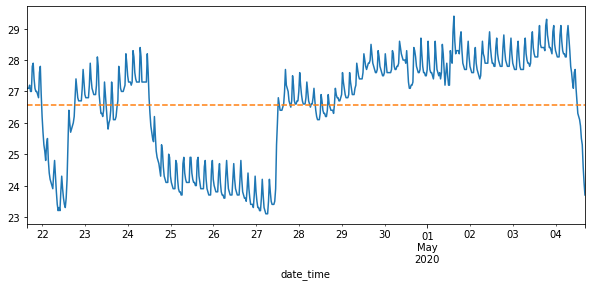

In [10]:
ax = df.set_index("date_time")["temperature"].plot.line(figsize=(10, 4))
ax.axhline(df["temperature"].mean(), c="C1", ls="--");

As seen in the above plot, we want the sum of the time of the data above the dashed line (mean temperature). 
An easy approach would be to segment our data around a condition (i.e., "is above mean temperature", True or False) and sum the time deltas of the segmented data points (think Riemann sum).
The accuracy of this approach would be limited by the temporal resolution of our data.

In [11]:
df_time_temp_threshold = (
    df
    # get the time delta each recording represents
    # and replace (`fillna`) not-a-time (NaT) values with 0
    .pipe(
        lambda x: x.assign(
            time_delta=x["date_time"].diff().fillna(pd.Timedelta(seconds=0))
        )
    )
    # convert time to numeric (i.e., hours)
    .pipe(lambda x: x.assign(time_delta=x["time_delta"].dt.total_seconds() / (60 * 60)))
    # flag the values that are above the threshold
    .pipe(lambda x: x.assign(is_above=x["temperature"] > x["temperature"].mean()))
    # drop unneeded columns
    .drop(["temperature", "humidity"], axis="columns")
    # pivot around threshold flag and sum time
    .groupby("is_above").sum()
    # create percentage column
    .pipe(lambda x: x.assign(percent=x["time_delta"] / x["time_delta"].sum() * 100))
)

df_time_temp_threshold

,time_delta,percent
is_above,,
False,114.0,36.421725
True,199.0,63.578275


Ta-da!
It appears that 199h or 63.6% of the time was spent above the mean temperature.

### Humidity in Two Dimensions

For our final question, we will be expanding our data into two dimensions: periods of the day and day of week.
This kind of question often arises when we're trying to spot environmental and external trends.
For example, do business hours, day/night cycles, or weekday vs weekends affect the data?

As an alternative example, [Google Analytics](https://analytics.google.com/) asks a similar type of question: "When do your users visit?".
The resulting `Users by time of day` visualization is a great approach to understanding external influences on your dataset.

![Example of `users by time of day`.](2020-10-25-09-00-41.png)

For the transformation of humidity data, this will require us to both resample our data with respect to time (i.e., create time periods) and group the data with respect to day of the week.
Fortunately, `pandas` makes this pretty straight forward:

In [12]:
# use the built-in package `calendar` to get an array
# that represents the ordered days of the week
from calendar import day_name

df_2d_humidity = (
    df
    # create time series index
    .set_index("date_time")
    # resample the data into 4h periods
    .resample("4H")
    # take the max of the resampled data
    .max()
    # extract the day of week as an ordered Categorical data type
    .pipe(
        lambda x: x.assign(
            day=pd.Categorical(
                # the given day_name values
                values=x.index.day_name(),
                # the correct calendar order
                categories=list(day_name),
                ordered=True,
            )
        )
    )
    # sort by day of the week
    .pipe(lambda x: x.sort_values("day"))
    # extract the hour of day
    .pipe(lambda x: x.assign(hour=x.index.hour))
    # drop unneeded columns
    .drop("temperature", axis="columns")
    # group by our days and hours
    .groupby(["day", "hour"])
    # take the max value of the groupings
    .max()
    # pivot data from grouped rows to 2D matrix
    .unstack(level=0)
    # drop redundant `humidity` column index
    .droplevel(0, axis="columns")
)

df_2d_humidity

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
0,6.8,2.8,3.6,3.2,5.5,5.8,6.3
4,6.4,2.6,3.3,4.6,5.8,5.3,6.9
8,6.6,2.7,2.9,5.0,7.0,4.9,7.0
12,6.3,10.1,3.2,6.4,20.1,4.6,7.2
16,3.0,4.2,2.9,5.8,9.3,4.7,7.4
20,2.3,3.2,3.0,5.3,6.7,5.3,7.8


And there we have it.
Each row of this transformation represents a single period of time, divided over days of the week (columns).
From the raw data, we can already see that noon tends to be an outlier and Wednesdays have relatively low humidity.

## Load: Generate Pretty and Useful Outputs

The final phase of an ETL workflow, `Load`, usually refers to the insertion of data into the final target database.
In a more general context, we are preparing the data for a desired output format, whether than be other databases, plots for a report, or CSV files for other spreadsheet users.

### Save Your Raw Data!

I personally always begin by saving my (new, clean) raw data back to CSV for safe keeping.
This offers other non-technical people Excel-based access to the same data that was used to generate pretty plots and reports.

In [13]:
# structure all the DataFrames into a simple dict to make for efficient processing
dfs = {
    "data-cleaned": df,
    "data-humidity-day": df_2d_humidity,
    "data-daily": df_daily,
    "data-temp-threshold": df_time_temp_threshold,
}

# iterate and save the data to CSV
for name, data in dfs.items():
    data.to_csv(f"{name}.csv", index=False)

### Pretty Plots

The target output for most hardware engineering projects is a pretty plot for a report.
A well-crafted visualization can make or break a design decision.

Our first step is to set up our global plotting settings:

In [14]:
# import matplotlib as the core plotting framework
from matplotlib import pyplot as plt
import matplotlib as mpl

# we can also import seaborn for some fancy plots
import seaborn as sns

# remove some spines for aesthetics
# (spines are the lines connecting the axis tick marks)
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

# best fig size for my blog
FIG_SIZE = (10, 4)

Next, we will go through our transformed data and generate useful plots to visualize their meaning.

#### Raw Data vs Time

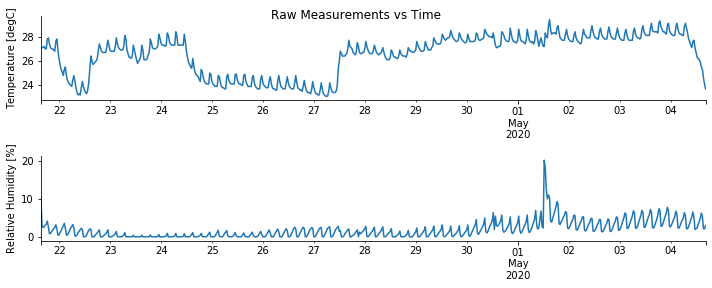

In [15]:
# use matplotlib for more fine-grained control
fig, axes = plt.subplots(nrows=2, figsize=FIG_SIZE)

# plot data on two subplots
df.set_index("date_time")["temperature"].plot.line(ax=axes[0])
df.set_index("date_time")["humidity"].plot.line(ax=axes[1])

# fig title and axis labels
fig.suptitle("Raw Measurements vs Time")
[ax.set_xlabel(None) for ax in axes]
axes[0].set_ylabel("Temperature [degC]")
axes[1].set_ylabel("Relative Humidity [%]")

# prepare output
fig.tight_layout()
fig.savefig("my-output-path.pdf")

#### Descriptive Statistics vs Time

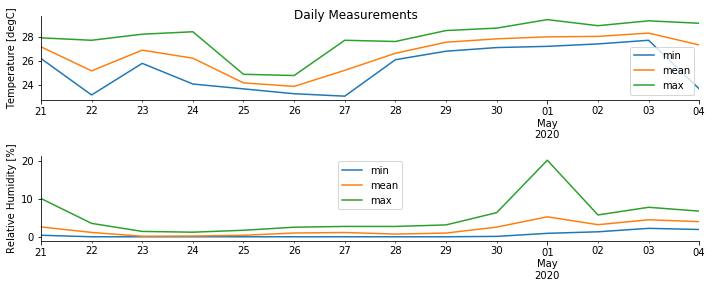

In [16]:
# use matplotlib for more fine-grained control
fig, axes = plt.subplots(nrows=2, figsize=FIG_SIZE)

# plot data on two subplots
df_daily["temperature"].plot.line(ax=axes[0])
df_daily["humidity"].plot.line(ax=axes[1])

# fig title and axis labels
fig.suptitle("Daily Measurements")
[ax.set_xlabel(None) for ax in axes]
axes[0].set_ylabel("Temperature [degC]")
axes[1].set_ylabel("Relative Humidity [%]")

# prepare output
fig.tight_layout()
fig.savefig("my-output-path.pdf")

#### Humidity Heatmap by Time of Day

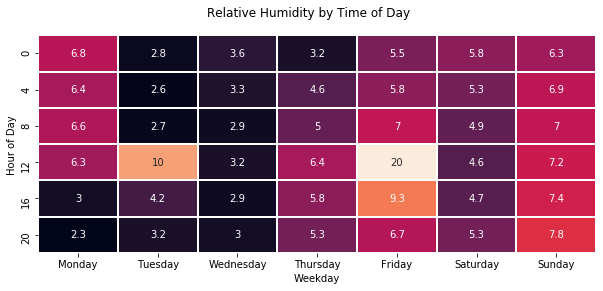

In [17]:
# use matplotlib for more fine-grained control
fig, ax = plt.subplots(figsize=FIG_SIZE)

# plot heatmap
sns.heatmap(
    # data we want to use
    data=df_2d_humidity,
    # make colourmap based on quantiles
    robust=True,
    # mark values in each cell
    annot=True,
    # add lines around each cell
    linewidths=1,
    # don't need colourbar with cell values
    cbar=False,
    # use matplotlib axis
    ax=ax,
)

# fig title and axis labels
fig.suptitle("Relative Humidity by Time of Day")
ax.set_xlabel("Weekday")
ax.set_ylabel("Hour of Day")

# prepare output
fig.savefig("my-output-path.pdf")

## Discussion

A Python-based workflow for data processing can seem daunting at first, but can really unlock the next level of manipulation and analysis once you get the hang of it.
While this blog post sectioned the code into chunks and snippets, it was actually written as a [Jupyter Notebook](https://jupyter.org/), mixing both the code and text into a single document.
Think about how powerful this is: your report and data analysis can live in a single document and single source of truth.
If you're extra curious, you can find the source code (i.e., the raw Jupyter Notebook) in [my website's public repository](https://github.com/nnadeau/nicholasnadeau-me).

For me personally, the real win of this workflow is keeping the [original logger data](data.xls) untouched and pure.
No possibility of accidentally changing the data and hitting `Ctrl+S` in Excel.
The workflow is repeatable, deterministic, and the analysis can be audited alongside the results for extra transparency.